In [1]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
from dltool import cv,test,plot
import dltool.train as dltrain
import torchvision.models as models

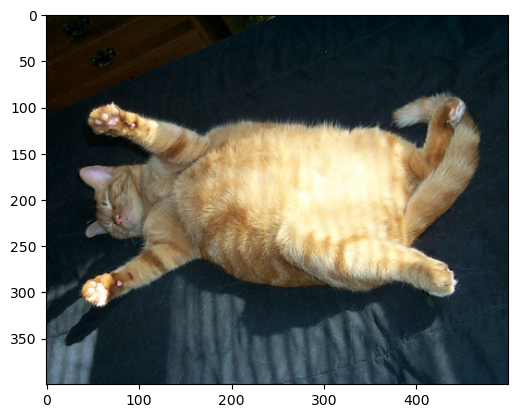

In [2]:
img = Image.open('../img/cat1.jpg')
plt.imshow(img)

In [3]:
def apply(img, aug, num_rows=2,num_cols=4,scale=1.5):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  cv.show_images(Y, num_rows, num_cols, scale=scale)

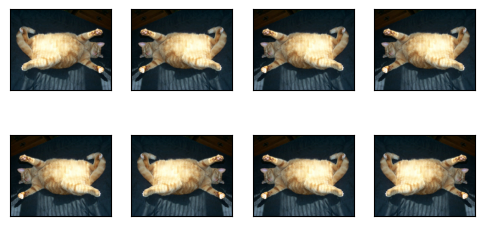

In [4]:
# 左右翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

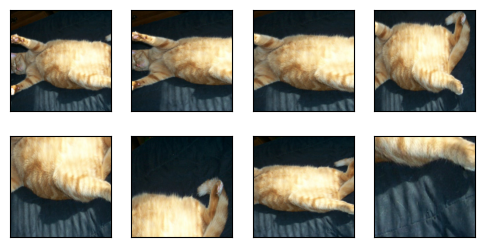

In [5]:
# 随机裁剪，降低模型对位置的敏感性
shape_aug = torchvision.transforms.RandomResizedCrop(
  (200,200), scale=(0.1,1), ratio=(0.5,2)
)
apply(img, shape_aug)

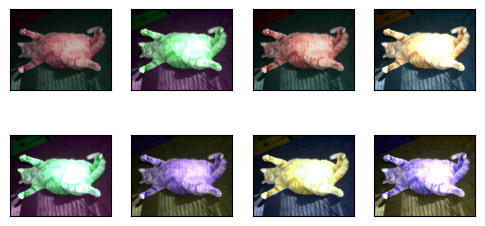

In [6]:
# 改变颜色：亮度、对比度、饱和度、色调
apply(img, torchvision.transforms.ColorJitter(
  brightness=0.5, contrast=0, saturation=0, hue=0.5
))

使用Compose综合一下

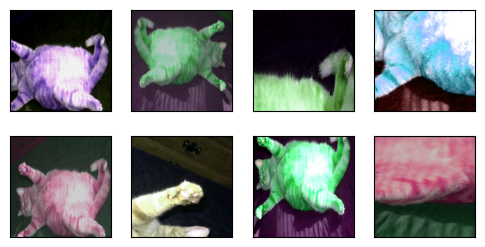

In [7]:
color_aug = torchvision.transforms.ColorJitter(
  brightness = 0.5,
  contrast = 0.5,
  saturation = 0.5,
  hue = 0.5
)
augs = torchvision.transforms.Compose([
  torchvision.transforms.RandomHorizontalFlip(),
  color_aug,
  shape_aug
])
apply(img, augs)

# 使用图像增广训练

Files already downloaded and verified


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

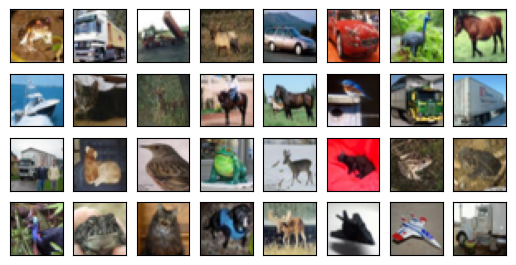

In [8]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",download=True)
cv.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [9]:
# 用ToTensor转换
train_augs = torchvision.transforms.Compose([
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.ToTensor()
])

test_augs = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor()
])

In [10]:
# 读取和增广图像
def load_cifar10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                         transform=augs, download=True)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=is_train, num_workers=4)
  return dataloader

In [11]:
# 多GPU训练
def train_batch(net, X, y, loss, trainer, devices):
  """用多GPU进行小批量训练"""
  if isinstance(X, list):
    # 微调BERT中所需
    X = [x.to(devices[0]) for x in X]
  else:
    X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred, y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = dltrain.accuracy(pred, y)
  return train_loss_sum, train_acc_sum

In [12]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,devices=[dltrain.try_gpu(0)]):
  timer, num_batches = test.Timer(), len(train_iter)
  animator = plot.Animator(xlabel='epoch', xlim=[1,num_epochs], ylim=[0,1],legend=['train loss','train acc','test acc'])
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    # 训练损失，训练准确度，实例数，特点数
    metric = dltrain.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch(
        net, features, labels, loss, trainer, devices
      )
      metric.add(l,acc,labels.shape[0],labels.numel())
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
    test_acc = dltrain.evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch+1,(None,None,test_acc))
  print(f'loss {metric[0] / metric[2]:.3f}, train acc '
        f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on ' f'{str(devices)}')

In [13]:
batch_size, devices, net = 256, [dltrain.try_gpu(0)],  models.resnet18(10,3)

/data2/fyang/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' and 'progress' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/data2/fyang/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
def init_weights(m):
  if type(m) in [nn.Linear, nn.Conv2d]:
    nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  loss = nn.CrossEntropyLoss(reduction="none")
  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  train(net, train_iter, test_iter, loss, trainer, 20, devices)

loss 0.189, train acc 0.935, test acc 0.754
13655.7 examples/sec on [device(type='cuda', index=0)]


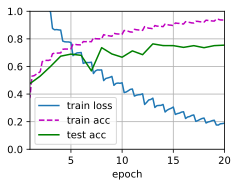

In [15]:
train_with_data_aug(train_augs, test_augs, net)